<a href="https://colab.research.google.com/github/Shelly10-10/flood_prediction/blob/main/Disaster.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import pandas as pd
df=pd.read_csv("improved_flood_dataset.csv")
flood_counts=df['Flood_Reported'].value_counts()
print(flood_counts)

Flood_Reported
0    7136
1    2864
Name: count, dtype: int64


In [11]:
from sklearn.metrics import confusion_matrix
# Separate classes
grade_mapping = {
    'A':4,
    'B':3,
    'C':2,
    'D':1,
    'E':0
}
df['Infrastructure_Grade'] = df['Infrastructure_Grade'].map(grade_mapping)

df_0 = df[df['Flood_Reported'] == 0]
df_1 = df[df['Flood_Reported'] == 1]

# Randomly sample 100 from each
df_0_sample = df_0.sample(n=2000, random_state=42)
df_1_sample = df_1.sample(n=2000, random_state=42)

# Combine and shuffle
df_balanced = pd.concat([df_0_sample, df_1_sample]).sample(frac=1, random_state=42).reset_index(drop=True)
from sklearn.model_selection import train_test_split

X = df_balanced.drop(columns=['Flood_Reported','Date','Region','Flood_Risk_Score'])
y = df_balanced['Flood_Reported']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100,max_depth=10,random_state=42)
model.fit(X_train, y_train)

# Evaluate on internal test
from sklearn.metrics import classification_report
y_pred_internal = model.predict(X_test)
print("Internal Test Report:\n", classification_report(y_test, y_pred_internal))
# Drop the 2000 training rows from the full dataset to get the external rows
external_df = df.drop(df_balanced.index).copy()

X_external = external_df.drop(columns=['Flood_Reported','Date','Region','Flood_Risk_Score'])
y_external = external_df['Flood_Reported']

# Predict and evaluate
y_pred_external = model.predict(X_external)

print("External Test Report:\n", classification_report(y_external, y_pred_external))
#Here I haved removed the flood_risk_score to make the model realistic detecting 95%of the actual flood occurrence

Internal Test Report:
               precision    recall  f1-score   support

           0       0.97      0.94      0.95       400
           1       0.94      0.97      0.95       400

    accuracy                           0.95       800
   macro avg       0.95      0.95      0.95       800
weighted avg       0.95      0.95      0.95       800

External Test Report:
               precision    recall  f1-score   support

           0       0.99      0.95      0.97      4268
           1       0.89      0.98      0.93      1732

    accuracy                           0.96      6000
   macro avg       0.94      0.97      0.95      6000
weighted avg       0.96      0.96      0.96      6000



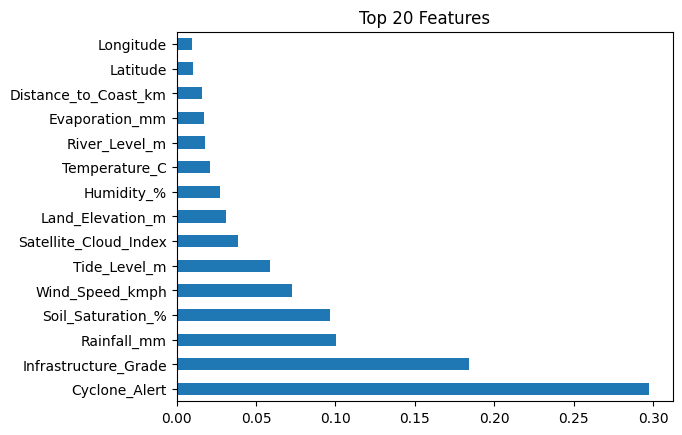

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh')
plt.title("Top 20 Features")
plt.show()


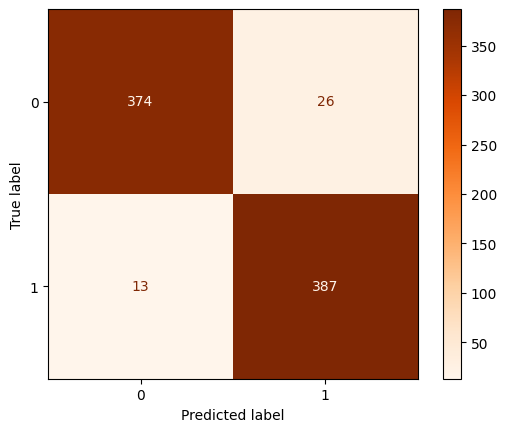

In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm_ext = confusion_matrix(y_test, y_pred_internal)
disp_ext = ConfusionMatrixDisplay(confusion_matrix=cm_ext, display_labels=model.classes_)
disp_ext.plot(cmap='Oranges')

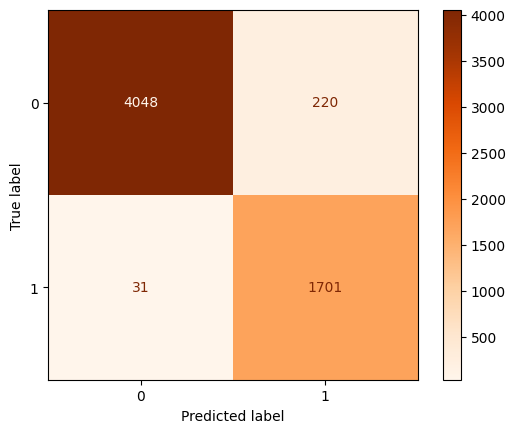

In [14]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm_ext = confusion_matrix(y_external, y_pred_external)
disp_ext = ConfusionMatrixDisplay(confusion_matrix=cm_ext, display_labels=model.classes_)
disp_ext.plot(cmap='Oranges')

In [19]:
pip install joblib

In [20]:
import joblib

# Save the model to a file
joblib.dump(model, 'random_forest_flood_model.pkl')


['random_forest_flood_model.pkl']

In [21]:
from sklearn.model_selection import cross_val_score
import numpy as np

# 5-fold Cross-validation on the training data
scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')

print("Cross-validation scores:", scores)
print("Mean CV accuracy:", np.mean(scores))


Cross-validation scores: [0.94375   0.95625   0.959375  0.9484375 0.94375  ]
Mean CV accuracy: 0.9503124999999999


In [23]:
df_0_sample=df_0.sample(n=2000,random_state=42)
df_1_sample=df_1.sample(n=2000,random_state=42)
df_balanced=pd.concat([df_0_sample,df_1_sample]).sample(frac=1).reset_index(drop=True)#The index is reset for new dataset

#Splitting into training and testing
X=df_balanced.drop(columns=['Flood_Reported','Date','Region','Flood_Risk_Score'])
y=df_balanced['Flood_Reported']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

#Features Scaling must be done in SVM
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
X_train_scaled=scaler.fit_transform(X_train)
X_test_scaled=scaler.transform(X_test)

In [32]:
from sklearn.svm import SVC
svm_model=SVC(kernel='rbf', C=1.0, gamma='scale')
svm_model.fit(X_train_scaled, y_train)

from sklearn.metrics import classification_report
y_pred_internal=svm_model.predict(X_test_scaled)
print("Internal test reports:\n", classification_report(y_test,y_pred_internal))

external_df = df.drop(df_balanced.index).copy()
X_external = external_df.drop(columns=['Flood_Reported','Date','Region','Flood_Risk_Score'])
y_external = external_df['Flood_Reported']

# Scale external data using the **same scaler**
X_external_scaled = scaler.transform(X_external)

y_pred_external = svm_model.predict(X_external_scaled)
print("External Test Report:\n", classification_report(y_external, y_pred_external))


Internal test reports:
               precision    recall  f1-score   support

           0       0.98      0.96      0.97       400
           1       0.96      0.98      0.97       400

    accuracy                           0.97       800
   macro avg       0.97      0.97      0.97       800
weighted avg       0.97      0.97      0.97       800

External Test Report:
               precision    recall  f1-score   support

           0       1.00      0.96      0.98      4268
           1       0.90      1.00      0.95      1732

    accuracy                           0.97      6000
   macro avg       0.95      0.98      0.96      6000
weighted avg       0.97      0.97      0.97      6000



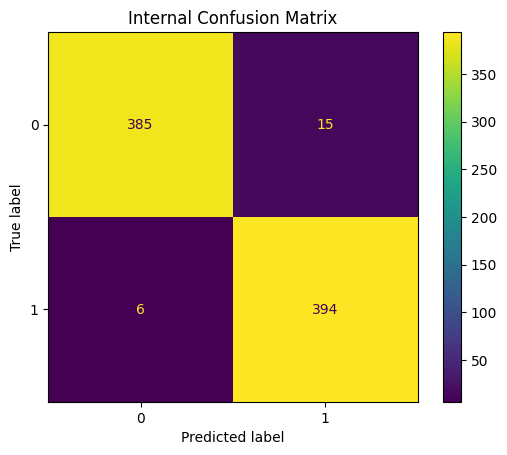

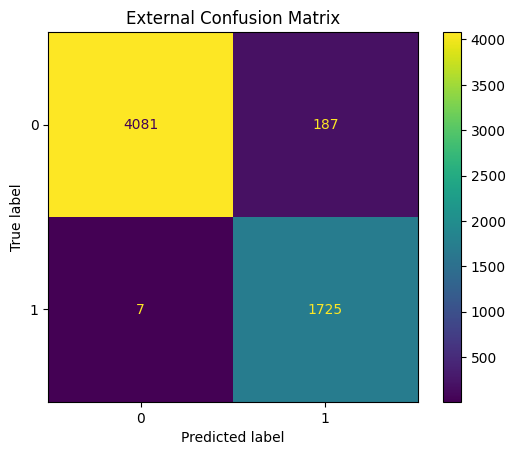

In [33]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Internal confusion matrix
cm_internal = confusion_matrix(y_test, y_pred_internal)
disp_internal = ConfusionMatrixDisplay(confusion_matrix=cm_internal, display_labels=svm_model.classes_)
disp_internal.plot()
plt.title("Internal Confusion Matrix")
plt.show()

# External confusion matrix
cm_external = confusion_matrix(y_external, y_pred_external)
disp_external = ConfusionMatrixDisplay(confusion_matrix=cm_external, display_labels=svm_model.classes_)
disp_external.plot()
plt.title("External Confusion Matrix")
plt.show()



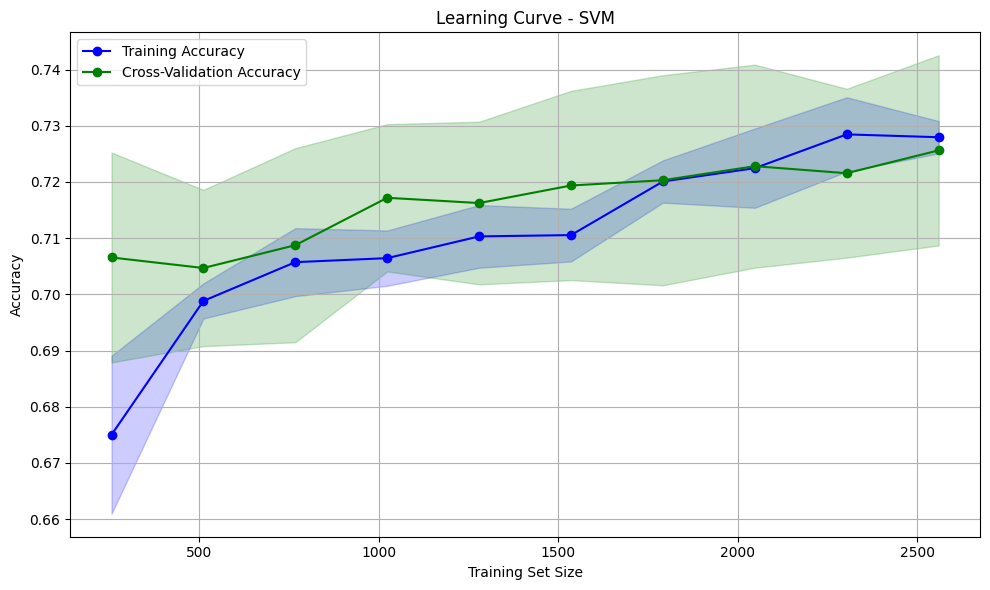

In [27]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np

train_sizes, train_scores, val_scores = learning_curve(
    svm_model, X_train, y_train,
    cv=5,
    scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 10),
    random_state=42
)

# Calculate means and standard deviations
train_mean = train_scores.mean(axis=1)
train_std = train_scores.std(axis=1)
val_mean = val_scores.mean(axis=1)
val_std = val_scores.std(axis=1)

# Plotting the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Training Accuracy')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color='blue')

plt.plot(train_sizes, val_mean, 'o-', color='green', label='Cross-Validation Accuracy')
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.2, color='green')

plt.title('Learning Curve - SVM')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.grid()
plt.tight_layout()
plt.show()


In [34]:
import joblib

# Save the model to a file
joblib.dump(svm_model, 'svm_flood_model.pkl')

['svm_flood_model.pkl']